<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Capstone Project** 
# **Real-Time Facial Emotion Recognition - Notebook 1**

## Background

## Problem Statement

To create a model that can **accurately distinguish emotions based on facial expressions**.

The models are evaluated based on the following criteria:

1. Accuracy scores (the higher, the better)
2. Delta between train and test scores (the smaller, the better)

## Structure & Workflow

To organise my work better, I have organised this project into two notebooks, across six parts: 

**Notebook 1:** 
* Part 1 : Data Import
* Part 2: Exploratory Data Analysis

**Notebook 2:**
* Part 3: Data Preprocessing
* Part 4: Baseline Model: A CNN model built from scratch
* Part 5: Transfer Learning & Model Evaluation
* Part 6: Model Deployment

In [ ]:
# import required libraries/packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import PIL
from PIL import Image
from zipfile import ZipFile

from sklearn.decomposition import PCA
from math import ceil

pd.set_option('display.max_colwidth', 500)

## 1. Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('/content/drive/MyDrive/data/fer2013.zip','r') as zipObj:
  zipObj.extractall('/data')

path = '/data/fer2013/'

In [ ]:
data = []
for p_folder in sorted(os.listdir(path)):
    for s_folder in sorted(os.listdir(path+'/'+p_folder)):
          for file in sorted(os.listdir(path+'/'+p_folder+'/'+s_folder)):            
              file_path = os.path.join(path+'/'+p_folder+'/'+s_folder)
              data.append((p_folder,s_folder, file,file_path+'/'+file))

df = pd.DataFrame(data, columns=['parent_folder','label','file_name','file_path'])
df

,parent_folder,label,file_name,file_path
0,test,angry,PrivateTest_10131363.jpg,/data/fer2013//test/angry/PrivateTest_10131363.jpg
1,test,angry,PrivateTest_10304478.jpg,/data/fer2013//test/angry/PrivateTest_10304478.jpg
2,test,angry,PrivateTest_1054527.jpg,/data/fer2013//test/angry/PrivateTest_1054527.jpg
3,test,angry,PrivateTest_10590091.jpg,/data/fer2013//test/angry/PrivateTest_10590091.jpg
4,test,angry,PrivateTest_1109992.jpg,/data/fer2013//test/angry/PrivateTest_1109992.jpg
...,...,...,...,...
35882,train,surprise,Training_99916297.jpg,/data/fer2013//train/surprise/Training_99916297.jpg
35883,train,surprise,Training_99924420.jpg,/data/fer2013//train/surprise/Training_99924420.jpg
35884,train,surprise,Training_99937001.jpg,/data/fer2013//train/surprise/Training_99937001.jpg
35885,train,surprise,Training_99951755.jpg,/data/fer2013//train/surprise/Training_99951755.jpg


## **2. Exploratory Data Analysis**

**Summary**

1. The FER2013 datatset is provided with an existing train/test split. We will further divide the train set into train/validation prior to modelling.     
2. There are 35,887 images in the FER2013 dataset, across 7 unique emotion classes: 28,709 images in train set (80%) and 7,178 images in test set (20%). 
3. The emotion classes are: happy, sad, neutral, fear, angry, surprise, disgust. 
4. There is an imbalanced distribution of images for each emotion class; especially with happy (too many) and disgust (too little) for both the train and test sets. 

In [ ]:
df.describe()

,parent_folder,label,file_name,file_path
count,35887,35887,35887,35887
unique,2,7,35885,35887
top,train,happy,Training_8475486.jpg,/data/fer2013//test/angry/PrivateTest_10131363.jpg
freq,28709,8989,2,1


In [ ]:
df.groupby(['parent_folder']).size()

parent_folder
test      7178
train    28709
dtype: int64

In [ ]:
df.groupby(['parent_folder']).label.value_counts(normalize=True)

parent_folder  label   
test           happy       0.247144
               sad         0.173725
               neutral     0.171775
               fear        0.142658
               angry       0.133463
               surprise    0.115770
               disgust     0.015464
train          happy       0.251315
               neutral     0.172942
               sad         0.168240
               fear        0.142708
               angry       0.139155
               surprise    0.110453
               disgust     0.015187
Name: label, dtype: float64

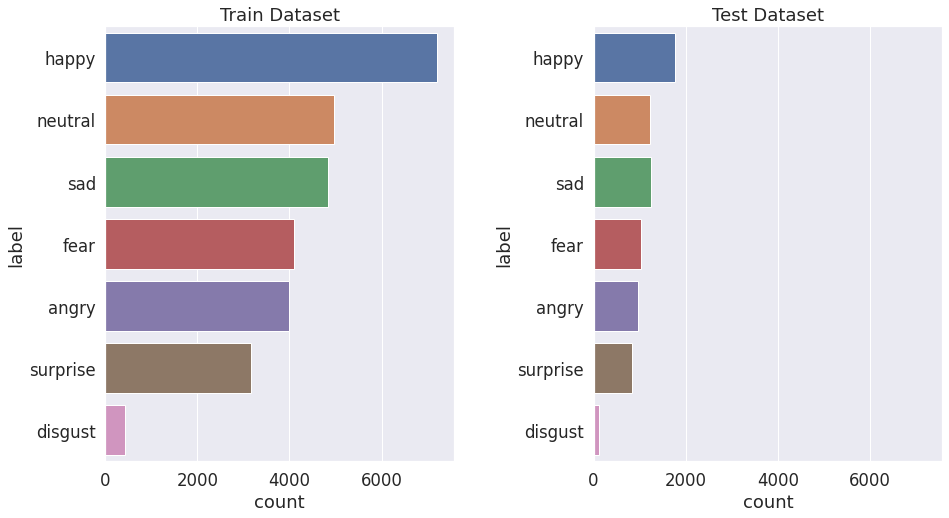

In [ ]:
sns.set(font_scale=1.5)
fig, axes = plt.subplots(1,2,figsize=(15,8),sharex=True)
sns.countplot(data=df[df['parent_folder'] == 'train'],
            y='label',
           order = df['label'].value_counts().index,ax=axes[0])
sns.countplot(data=df[df['parent_folder'] == 'test'],
            y='label',
           order = df['label'].value_counts().index,ax=axes[1])
axes[0].title.set_text('Train Dataset')
axes[1].title.set_text('Test Dataset')
plt.subplots_adjust(wspace=0.4)

**Observations:**

*   There is an imbalanced distribution of images for each emotion class; especially with happy (too many ~25%) and disgust (too little ~1%) for both the train and test sets. 
*   There are several techniques to tackle class imbalance for image: 

  1.   Undersampling the majority class: to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. 
  2.   Oversampling the minority class: to balance uneven datasets by duplicating random images from the minority class to ensure that all classes have the same number of images. 
  3. Merging similar classes that share similar features. 
  4. Performing data augmentation to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. 

Source: https://medium.com/mlearning-ai/computer-vision-how-to-tackle-the-problem-of-class-imbalance-in-image-datasets-d4d0ca6bd5db

**Decision:**

*   To tackle the class imbalance issue, I will **exclude disgust emotion class** from the multiclassification modelling steps. 
*   I will also **exclude neutral emotion class** as I find that it will not be very meaningful to identify 'neutral' facial expressions.





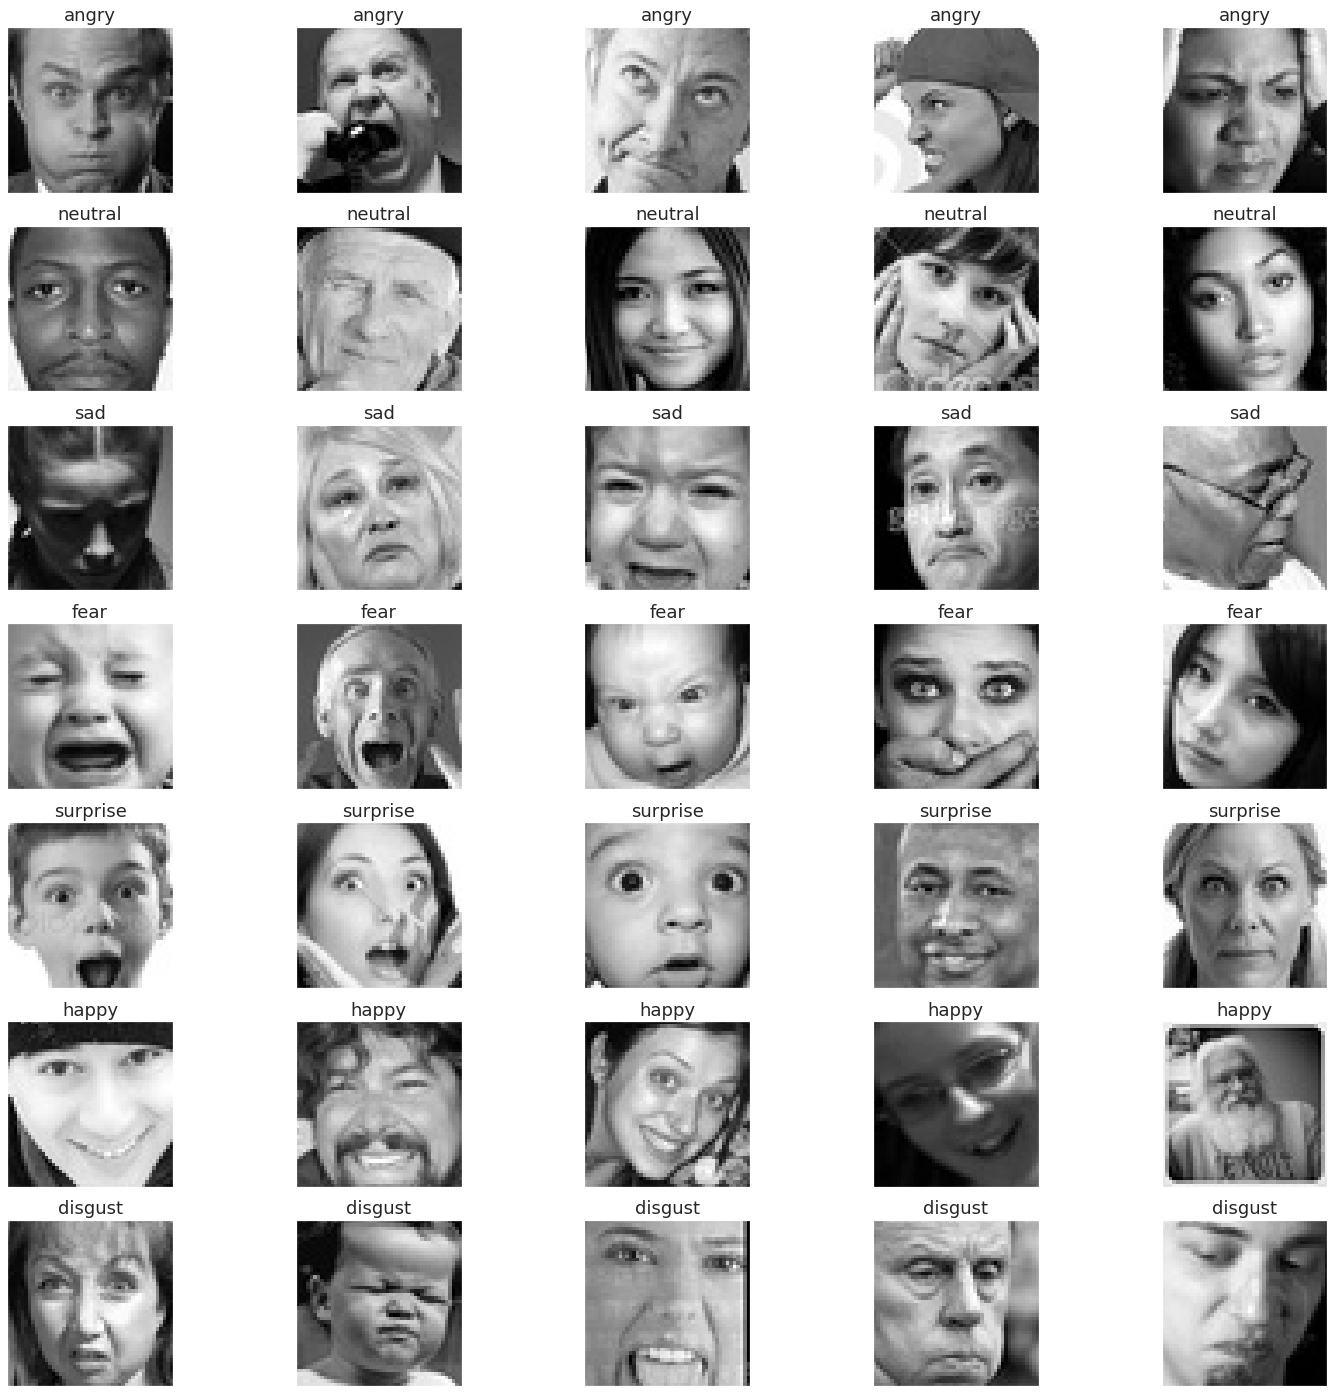

In [ ]:
temp = pd.DataFrame()

labels = ['angry','neutral','sad','fear','surprise','happy','disgust']

for l in labels: 
    temp = temp.append(df[df['label'] == l].sample(n=5,random_state=42))

temp = temp.reset_index()

fig,axes = plt.subplots(7,5,figsize=(25,25))
axes = axes.ravel()

for i in range(len(temp)):

    img = Image.open(temp['file_path'][i])
    axes[i].imshow(img,cmap='gray')
    axes[i].set_title(temp['label'][i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])


**Observations:**
1.   Images are grayscale with a size of 48 x 48 pixels.
2.   Inconsistencies in images:
 * Background color variations
 * Lighting variations
 * Posture variations
 * Angle variations (frontal vs side faces)
 * Occlusions e.g. eyeglasses, hand gestures
3. Incorrect or missing labels
4. Diverse representation of races and ages; might not take into account culture differences in expressing emotions.


### **Average Image for Each Emotion Class**



*   Firstly, we convert each image into a Numpy array to work directly with the pixel values. 
*   Then, we compute the average image by taking the average value of each pixel across all observations.



In [ ]:
angry_imgs = [fn for fn in os.listdir(f'{path}/train/angry')]
fear_imgs = [fn for fn in os.listdir(f'{path}/train/fear')]
happy_imgs = [fn for fn in os.listdir(f'{path}/train/happy')]
sad_imgs = [fn for fn in os.listdir(f'{path}/train/sad')]
surprise_imgs = [fn for fn in os.listdir(f'{path}/train/surprise')]
neutral_imgs = [fn for fn in os.listdir(f'{path}/train/neutral')]
disgust_imgs = [fn for fn in os.listdir(f'{path}/train/disgust')]

In [ ]:
# making n X m matrix
def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# find mean
def find_mean_img(full_mat, title, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

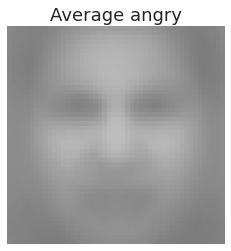

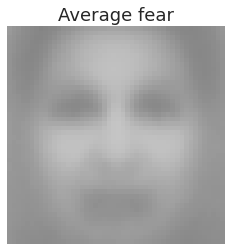

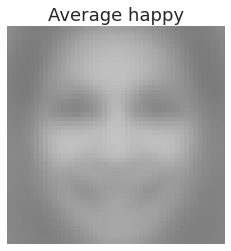

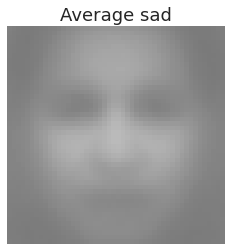

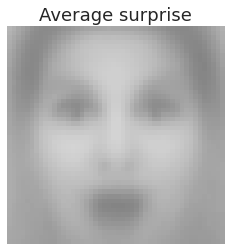

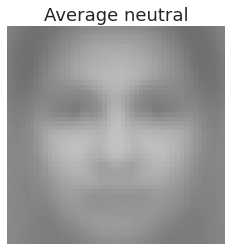

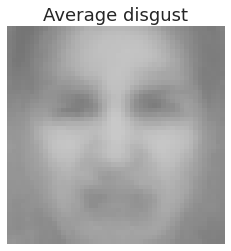

In [ ]:
# run it on our folders
angry_images = img2np(f'/data/fer2013/train/angry/', angry_imgs)
fear_images = img2np(f'/data/fer2013/train/fear/', fear_imgs)
happy_images = img2np(f'/data/fer2013/train/happy/', happy_imgs)
sad_images = img2np(f'/data/fer2013/train/sad/', sad_imgs)
surprise_images = img2np(f'/data/fer2013/train/surprise/', surprise_imgs)
neutral_images = img2np(f'/data/fer2013/train/neutral/', neutral_imgs)
disgust_images = img2np(f'/data/fer2013/train/disgust/', disgust_imgs)

angry_mean = find_mean_img(angry_images, 'angry')
fear_mean = find_mean_img(fear_images, 'fear')
happy_mean = find_mean_img(happy_images, 'happy')
sad_mean = find_mean_img(sad_images, 'sad')
surprise_mean = find_mean_img(surprise_images, 'surprise')
neutral_mean = find_mean_img(neutral_images, 'neutral')
disgust_mean = find_mean_img(disgust_images, 'disgust')


**Observations:**
1.   Distinct facial features can be seen in the following emotions: 
 * Happy: upturned lips and more defined cheekbones
 * Surprise: wide eyes and slightly open mouth
 * Angry: furrowed eyebrows
 * Disgust: furrowed eyebrows and slightly scrunched nose
2.   Similar facial features for neutral, sad and fear.


### **Contrast between Average Images**

(-0.5, 47.5, 47.5, -0.5)

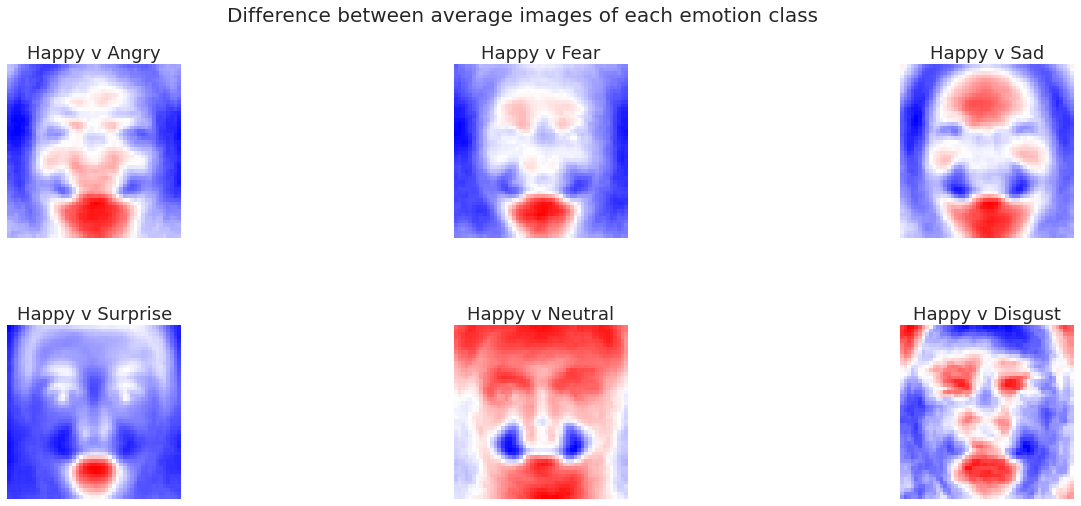

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = happy_mean - angry_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Happy v Angry')
ax[0].axis('off')

contrast_mean_2 = happy_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Happy v Fear')
ax[1].axis('off')

contrast_mean_3 = happy_mean - sad_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Happy v Sad')
ax[2].axis('off')

contrast_mean_4 = happy_mean - surprise_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Happy v Surprise')
ax[3].axis('off')

contrast_mean_5 = happy_mean - neutral_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Happy v Neutral')
ax[4].axis('off')

contrast_mean_6 = happy_mean - disgust_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Happy v Disgust')
ax[5].axis('off')

(-0.5, 47.5, 47.5, -0.5)

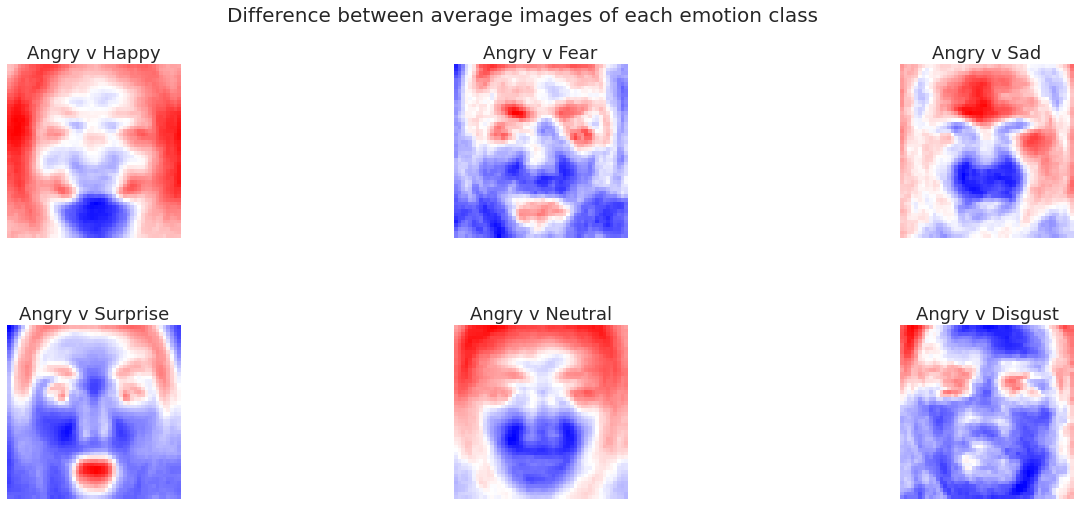

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = angry_mean - happy_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Angry v Happy')
ax[0].axis('off')

contrast_mean_2 = angry_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Angry v Fear')
ax[1].axis('off')

contrast_mean_3 = angry_mean - sad_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Angry v Sad')
ax[2].axis('off')

contrast_mean_4 = angry_mean - surprise_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Angry v Surprise')
ax[3].axis('off')

contrast_mean_5 = angry_mean - neutral_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Angry v Neutral')
ax[4].axis('off')

contrast_mean_6 = angry_mean - disgust_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Angry v Disgust')
ax[5].axis('off')

(-0.5, 47.5, 47.5, -0.5)

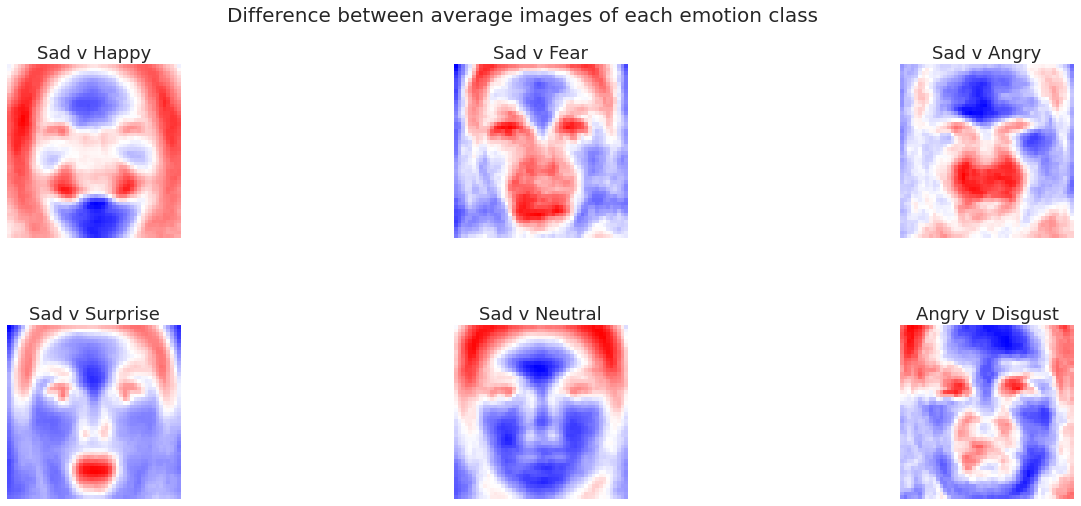

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = sad_mean - happy_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Sad v Happy')
ax[0].axis('off')

contrast_mean_2 = sad_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Sad v Fear')
ax[1].axis('off')

contrast_mean_3 = sad_mean - angry_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Sad v Angry')
ax[2].axis('off')

contrast_mean_4 = sad_mean - surprise_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Sad v Surprise')
ax[3].axis('off')

contrast_mean_5 = sad_mean - neutral_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Sad v Neutral')
ax[4].axis('off')

contrast_mean_6 = sad_mean - disgust_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Angry v Disgust')
ax[5].axis('off')

(-0.5, 47.5, 47.5, -0.5)

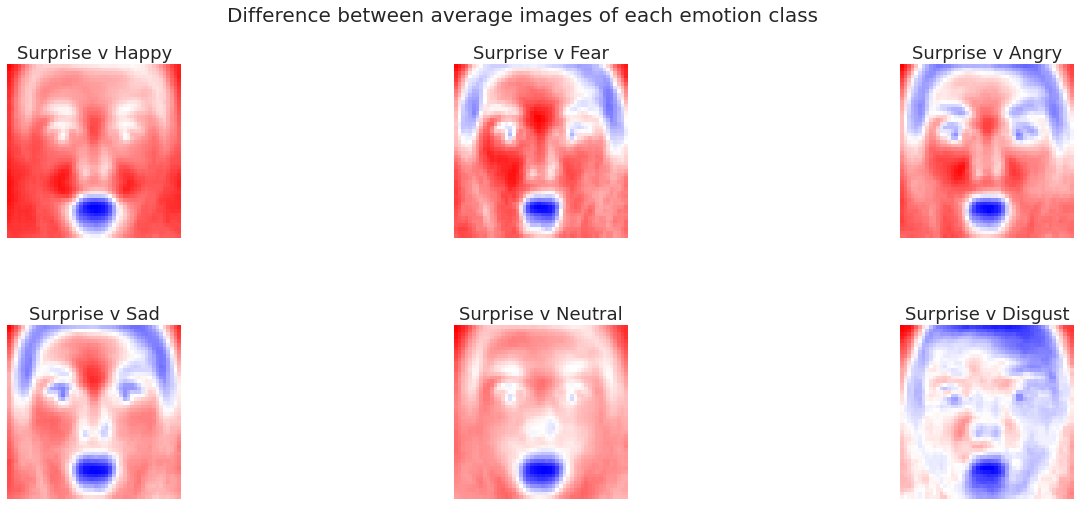

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = surprise_mean - happy_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Surprise v Happy')
ax[0].axis('off')

contrast_mean_2 = surprise_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Surprise v Fear')
ax[1].axis('off')

contrast_mean_3 = surprise_mean - angry_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Surprise v Angry')
ax[2].axis('off')

contrast_mean_4 = surprise_mean - sad_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Surprise v Sad')
ax[3].axis('off')

contrast_mean_5 = surprise_mean - neutral_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Surprise v Neutral')
ax[4].axis('off')

contrast_mean_6 = surprise_mean - disgust_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Surprise v Disgust')
ax[5].axis('off')

(-0.5, 47.5, 47.5, -0.5)

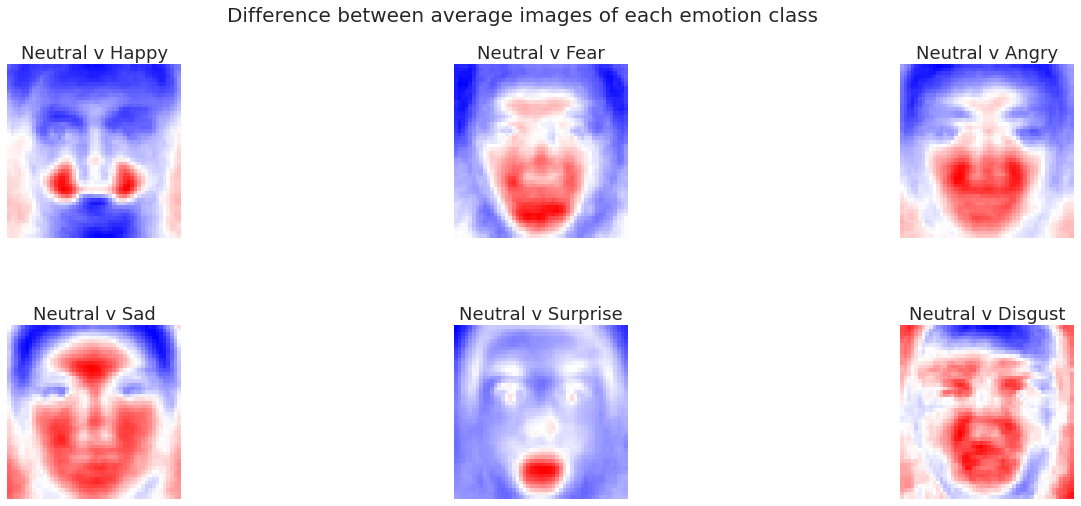

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = neutral_mean - happy_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Neutral v Happy')
ax[0].axis('off')

contrast_mean_2 = neutral_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Neutral v Fear')
ax[1].axis('off')

contrast_mean_3 = neutral_mean - angry_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Neutral v Angry')
ax[2].axis('off')

contrast_mean_4 = neutral_mean - sad_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Neutral v Sad')
ax[3].axis('off')

contrast_mean_5 = neutral_mean - surprise_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Neutral v Surprise')
ax[4].axis('off')

contrast_mean_6 = neutral_mean - disgust_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Neutral v Disgust')
ax[5].axis('off')

(-0.5, 47.5, 47.5, -0.5)

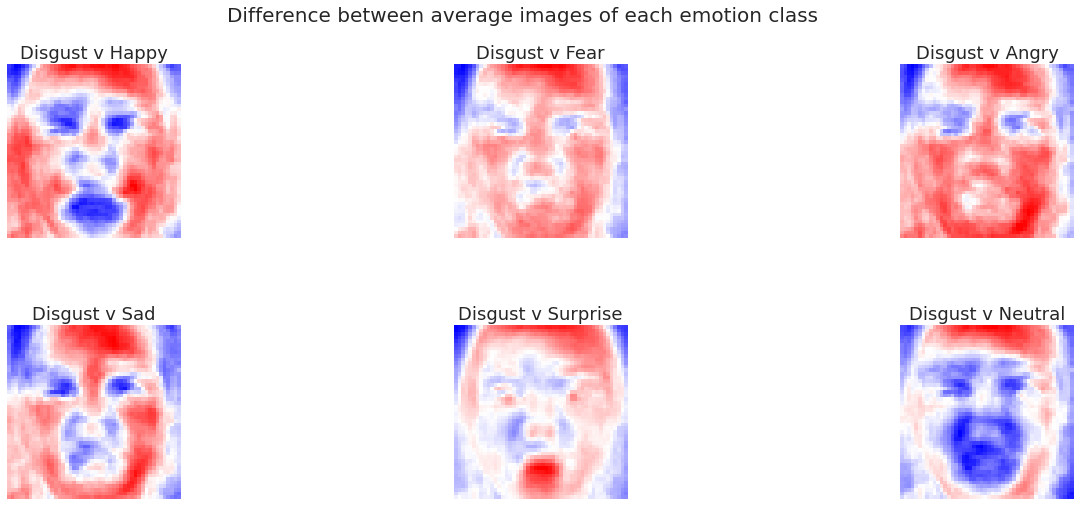

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols=3,figsize=(20,8))
fig.suptitle('Difference between average images of each emotion class', fontsize=20)
plt.subplots_adjust(hspace = 0.5,wspace=1)
ax = ax.ravel() 
    
contrast_mean_1 = disgust_mean - happy_mean
ax[0].imshow(contrast_mean_1, cmap='bwr')
ax[0].set_title(f'Disgust v Happy')
ax[0].axis('off')

contrast_mean_2 = disgust_mean - fear_mean
ax[1].imshow(contrast_mean_2, cmap='bwr')
ax[1].set_title(f'Disgust v Fear')
ax[1].axis('off')

contrast_mean_3 = disgust_mean - angry_mean
ax[2].imshow(contrast_mean_3, cmap='bwr')
ax[2].set_title(f'Disgust v Angry')
ax[2].axis('off')

contrast_mean_4 = disgust_mean - sad_mean
ax[3].imshow(contrast_mean_4, cmap='bwr')
ax[3].set_title(f'Disgust v Sad')
ax[3].axis('off')

contrast_mean_5 = disgust_mean - surprise_mean
ax[4].imshow(contrast_mean_5, cmap='bwr')
ax[4].set_title(f'Disgust v Surprise')
ax[4].axis('off')

contrast_mean_6 = disgust_mean - neutral_mean
ax[5].imshow(contrast_mean_6, cmap='bwr')
ax[5].set_title(f'Disgust v Neutral')
ax[5].axis('off')

**Observations:**

1.  Some emotion classes are easier to distinguish than others. E.g. for surprise, the open-mouth feature seems to be able to distinct it from other emotion classes. 
2. In contrast, for disgust, it seems difficult to distinguish this emotion from other emotion classes. 

### **Eigenimages: Visualising Components that Best Describe Each Emotion**

* We use a dimension reduction technique i.e. the principal component analysis to visualise the components that best describe each class. 
* The images below show the principal components that describe 70% of variability for each class. 

Angry Number of PC:  14


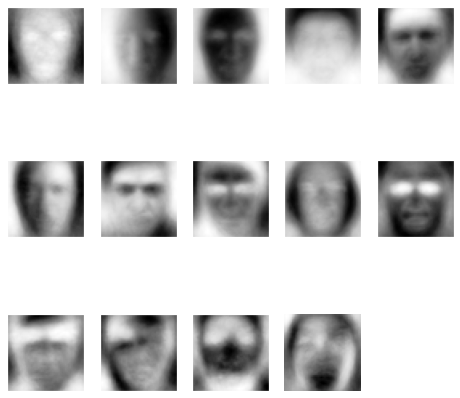

Fear Number of PC:  15


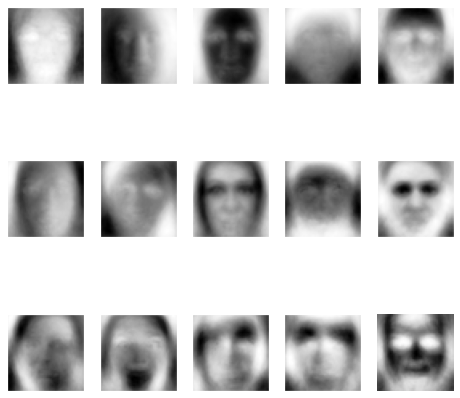

Happy Number of PC:  13


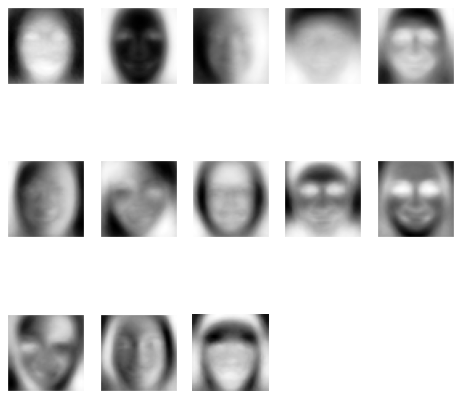

Sad Number of PC:  14


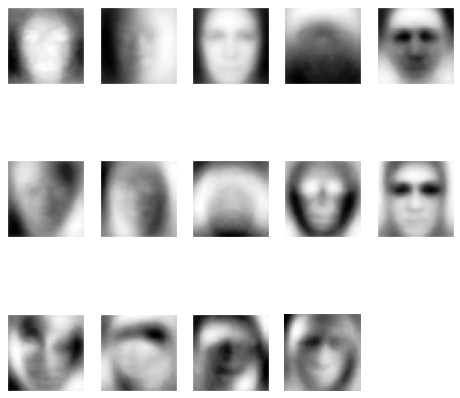

Surprise Number of PC:  14


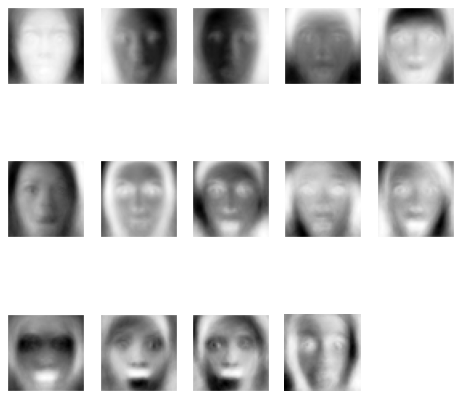

Neutral Number of PC:  12


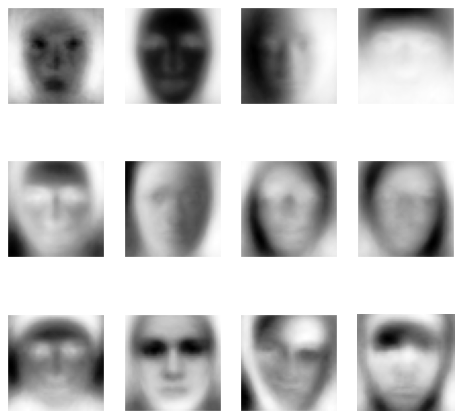

Disgust Number of PC:  9


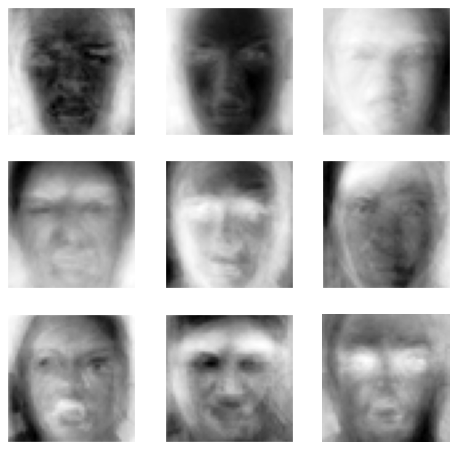

In [ ]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (48, 48)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print(title, 'Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (48, 48)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(angry_images, 'Angry'))
plot_pca(eigenimages(fear_images, 'Fear'))
plot_pca(eigenimages(happy_images, 'Happy'))
plot_pca(eigenimages(sad_images, 'Sad'))
plot_pca(eigenimages(surprise_images, 'Surprise'))
plot_pca(eigenimages(neutral_images, 'Neutral'))
plot_pca(eigenimages(disgust_images, 'Disgust'))


**Observations:**
1.   The eigenimages of surprise images show much more edge definitions around the mouth and eyes areas. 
2.   The eigenimages of angry and fear images show much more edge definitions around the eyes areas. 
3. The eigenimages of disgust does not show much edge definitions in any particular facial feature.


**Credits:**

* Eunjoo Byeon, "Exploratory Data Analysis Ideas for Image Classification". https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2